- plot 추가 (oil, k_weather, weather, cpi, exchange)

# 추가데이터 EDA
- 세계날씨(강수량,풍속,기온), 한국날씨(강수량,수온,기온), CPI지수, 유가, 환율
- 세계날씨는 주요6개국에 대하여 수집하였음
    - 오징어 : 페루, 중국, 칠레
    - 연어 : 노르웨이
    - 새우 : 베트남, 태국

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 원래 Setting

새로운 세팅방법이 안되서 일단 원래 setting을 추가하였습니다 ㅠㅠ

In [2]:
# System Libraries
import os
import warnings

# Data handling Libraries
import pandas as pd
import numpy as np

# Visuzliation Libraries
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

# Traning & Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Date Functions
from datetime import date, timedelta, datetime
from calendar import monthrange


def set_week(df, date):
    """
    dataframe 의 년월일 날짜 컬럼을 년 컬럼과 주차 컬럼으로 분리하는 함수
    :param df: datetime 형식의 컬럼을 가지고 있는 dataframe
    :param date: df에서 datetime 형식을 가진 컬럼명
    :return: date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    """
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)
    df.drop(date, axis=1, inplace=True)


def check_week(df):
    """
    dataframe에 sdate 과 edate 사이에 모든 데이터가 있는지 확인하는 함수
    :param df: 검사하고자 하는 dataframe (set_week 형태)
    :return: None
    """
    cnt = 0
    sdate = date(2015, 12, 28)  # start date
    edate = date(2019, 12, 30)  # end date
    delta = edate - sdate  # as timedelta
    mem = set()

    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        year, week = day.isocalendar()[0], day.isocalendar()[1]
        if year * 100 + week in mem:
            continue
        mem.add(year * 100 + week)
        if df[(df['year'] == year) & (df['week'] == week)].empty:
            print((year, week), end="")
            cnt += 1
    if cnt > 0:
        print()
    print("missing", cnt, "values")

    
# Wrangling Hypothesis Validation Functions
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred) ** 0.5


def train_model(train_data, target_data, model=LinearRegression()):  # baseline model : LinearRegression
    x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, random_state=0)

    model.fit(x_train, y_train)
    print("Model Training Complete!")

    pred_train, pred_test = model.predict(x_train), model.predict(x_test)

    plt.figure(figsize=(10, 8))
    #     plt.scatter(pred_train, y_train, s=10)
    sns.regplot(pred_train, y_train, color='g')
    plt.xlabel("Predicted price")
    plt.ylabel("Actual price")
    # plt.savefig(os.path.join(root, 'IMAGES', str(cnt) + '.png'), transparent=True)
    plt.show()

    # cvs = cross_val_score(model, x_test, y_test, cv = 5)
    # print(">> cross_val_score mean =", cvs.mean())
    print(">> RMSE train =", RMSE(y_train, pred_train))
    print(">> RMSE validation =", RMSE(y_test, pred_test))
    print(">> MAE train =", mean_absolute_error(pred_train, y_train))
    print(">> MAE validation =", mean_absolute_error(pred_test, y_test))
    print("-------------------------------------------------")

    return model


def print_importance(model, df, added_columns):
    importance = model.coef_
    fs_data = []
    for i, x in enumerate(importance):
        fs_data.append([abs(x), df.columns[i]])
    fs_data.sort(key=lambda x: x[0], reverse=True)

    # 추가한 컬럼의 중요도
    for i in range(len(fs_data)):
        if fs_data[i][1] in added_columns:
            print(fs_data[i][1], ":", fs_data[i][0], ">", i, "순위")
    print("-------------------------------------------------")
    print("총", len(fs_data), "개")

    return fs_data

# Setting

### Library

In [3]:
# # import Libraries & Functions
# from utillity import *

In [4]:
# Trun off warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# Visualization Setting
color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

In [6]:
root = os.path.join('/content/drive/MyDrive', 'DATA')

### Merging dataframes

In [7]:
from functools import reduce

def merge_df(df_list):
    return reduce(lambda  left,right: pd.merge(left,right, on=['year', 'week'], how='left'), df_list)

# Train Data

## Import Data

In [8]:
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'), usecols=["REG_DATE", "P_PRICE"])
df2 = pd.read_excel(os.path.join(root, 'train.xlsx'), usecols=["REG_DATE", "P_PRICE","P_NAME"])

## Preprocess

- 품목별로 나누어 날짜 처리
- 날짜 처리는 set_week를 통해 처리
- 중복되는 날짜의 price 평균을 구해서 하나의 날짜에 하나의 가격을 채움

In [9]:
df = df2.drop('P_NAME',axis=1)
set_week(df, 'REG_DATE')
df['price'] = df.groupby(['year', 'week']).transform('mean')
df.drop('P_PRICE',axis=1,inplace=True)
df.drop_duplicates(inplace=True)

In [10]:
set_week(df2, 'REG_DATE')

In [11]:
squid_price = df2[df2['P_NAME']=='오징어']
squid_price['price'] = squid_price.groupby(['year', 'week']).transform('mean')
squid_price.drop('P_PRICE',axis=1,inplace=True)
squid_price.drop_duplicates(inplace=True)

salmon_price = df2[df2['P_NAME']=='연어']
salmon_price['price'] = salmon_price.groupby(['year', 'week']).transform('mean')
salmon_price.drop('P_PRICE',axis=1,inplace=True)
salmon_price.drop_duplicates(inplace=True)

wshrimp_price = df2[df2['P_NAME']=='흰다리새우']
wshrimp_price['price'] = wshrimp_price.groupby(['year', 'week']).transform('mean')
wshrimp_price.drop('P_PRICE',axis=1,inplace=True)
wshrimp_price.drop_duplicates(inplace=True)

squid_price.drop('P_NAME',axis=1,inplace=True)
salmon_price.drop('P_NAME',axis=1,inplace=True)
wshrimp_price.drop('P_NAME',axis=1,inplace=True)

## Check

In [12]:
check_week(squid_price)

(2016, 6)(2017, 2)(2017, 40)
missing 3 values


In [13]:
check_week(salmon_price)

(2017, 2)
missing 1 values


In [14]:
check_week(wshrimp_price)

(2017, 2)
missing 1 values


## Filling Missing Values

- 결측값을 앞뒤 주차의 평균값으로 채움

In [15]:
def get_price_avg(df, year, week, value):
  return (df[(df['year'] == year) & (df['week'] == week + 1)].iloc[0][value] 
          + df[(df['year'] == year) & (df['week'] == week - 1)].iloc[0][value]) / 2

In [16]:
# 오징어 결측값 추가
squid_price = squid_price.append({'year' : 2016,
                                  'week' : 6,
                                  'price' : get_price_avg(squid_price,2016,6,'price'),},
                                 ignore_index=True)
squid_price = squid_price.append({'year' : 2017,
                                  'week' : 2,
                                  'price' : get_price_avg(squid_price,2017,2,'price'),},
                                 ignore_index=True)
squid_price = squid_price.append({'year' : 2017,
                                  'week' : 40,
                                  'price' : get_price_avg(squid_price,2017,40,'price'),},
                                 ignore_index=True)
# 연어 결측값 추가
salmon_price = salmon_price.append({'year' : 2017,
                                  'week' : 2,
                                  'price' : get_price_avg(salmon_price,2017,2,'price'),},
                                 ignore_index=True)
# 흰다리새우 결측값 추가
wshrimp_price = wshrimp_price.append({'year' : 2017,
                                  'week' : 2,
                                  'price' : get_price_avg(wshrimp_price,2017,2,'price'),},
                                 ignore_index=True)

In [17]:
check_week(squid_price)

missing 0 values


In [18]:
check_week(salmon_price)

missing 0 values


In [19]:
check_week(wshrimp_price)

missing 0 values


# OIL

- 수산물 수입 수출에서 유가는 아주 중요한 변수가 될것이라고 생각함
- 유가와 평균단가의 상관관계를 확인하고자함

- 유가 수입단가 상관관계 분석 -> df_oil의 wti 종가가 예민하게반응하는 값 ???
- ^ 이거 저랑 좀 다르게나오는것같아요

## Import Data

In [47]:
df_oil = pd.read_csv(os.path.join(root, 'raw_oil.csv'), usecols=["날짜", "종가"])
df_oil_dubai = pd.read_csv(os.path.join(root, 'raw_oil_dubai.csv'), usecols=["날짜", "종가"])
df_oil_brent = pd.read_csv(os.path.join(root, 'raw_oil_brent.csv'), usecols=["날짜", "종가"])

## EDA

In [48]:
plt.rcParams['figure.figsize'] = [15, 6]

(-40.0, 90.0)

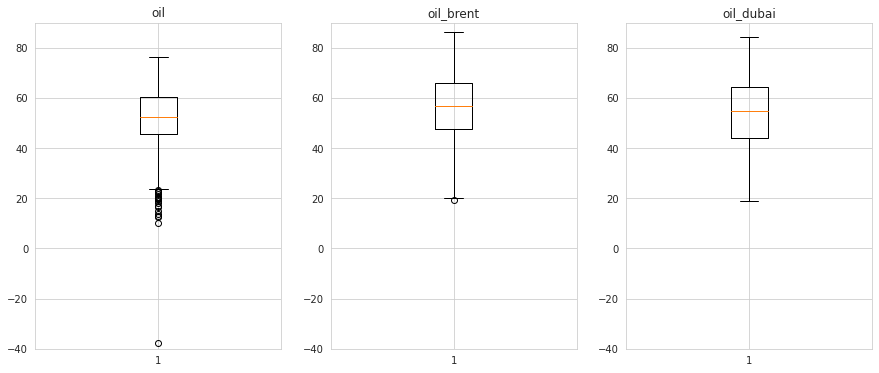

In [49]:
plt.subplot(131)
plt.boxplot(df_oil['종가'])
plt.title('oil')
plt.ylim(-40,90)

plt.subplot(132)
plt.boxplot(df_oil_brent['종가'])
plt.title('oil_brent')
plt.ylim(-40,90)

plt.subplot(133)
plt.boxplot(df_oil_dubai['종가'])
plt.title('oil_dubai')
plt.ylim(-40,90)

- oil 데이터에 이상치이 존재함

In [50]:
df_oil[df_oil['종가']<=0]

,날짜,종가
312,2020년 04월 20일,-37.63


In [51]:
df_oil.drop([312], inplace=True)

In [52]:
df_oil[df_oil['종가']<=0]

,날짜,종가


- 이상치 제거

In [53]:
df_oil.reset_index(inplace=True,drop=True)
df_oil_brent.reset_index(inplace=True,drop=True)
df_oil_dubai.reset_index(inplace=True,drop=True)

No handles with labels found to put in legend.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


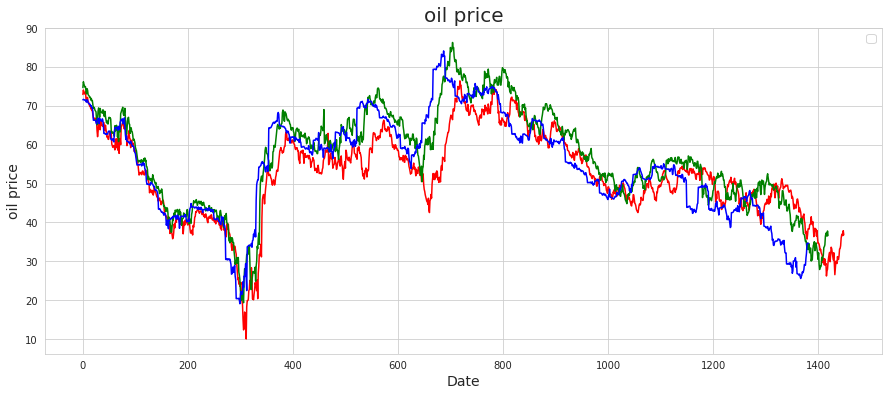

In [54]:
# df_oil.plot()
# df_oil_brent.plot()

plt.plot(df_oil.index, df_oil.종가, color='r')
plt.plot(df_oil_brent.index, df_oil_brent.종가, color='g')
plt.plot(df_oil_dubai.index, df_oil_dubai.종가, color='b')

plt.title('oil price', fontsize=20) 
plt.ylabel('oil price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

- 각 유가가 비슷한 그래프를 그리는것을 확인할 수 있다.

## Preprocess

In [55]:
from datetime import datetime
def preprocess_oil(df):
    df['date'] = pd.to_datetime(df['날짜'].str[:4] + df['날짜'].str[6:8] + df['날짜'].str[10:12])
    set_week(df, 'date')  # 날짜 데이터 정리
    df['oil'] = df[['year', 'week', '종가']].groupby(['year', 'week']).transform('mean')
    df.drop(columns = ['날짜', '종가'], inplace=True, axis=1)
    df.drop_duplicates(inplace=True)
    return df

In [56]:
df_oil = preprocess_oil(df_oil)
df_oil_dubai = preprocess_oil(df_oil_dubai)
df_oil_brent = preprocess_oil(df_oil_brent)

날짜별 종가 데이터를 평균내어 한 날짜에 한 종가가 있는 데이터를 만듬

In [57]:
df_m_oil = pd.merge(df_oil,df_oil_brent,on=['year','week'])
df_m_oil = pd.merge(df_m_oil,df_oil_dubai,on=['year','week'])
df_m_oil.rename(columns = {'oil_x' : 'oil_wti', 'oil_y' : 'oil_brent', 'oil' : 'oil_dubai'}, inplace = True)

df_m_oil = pd.merge(df_m_oil,df,on=['year','week'])

No handles with labels found to put in legend.


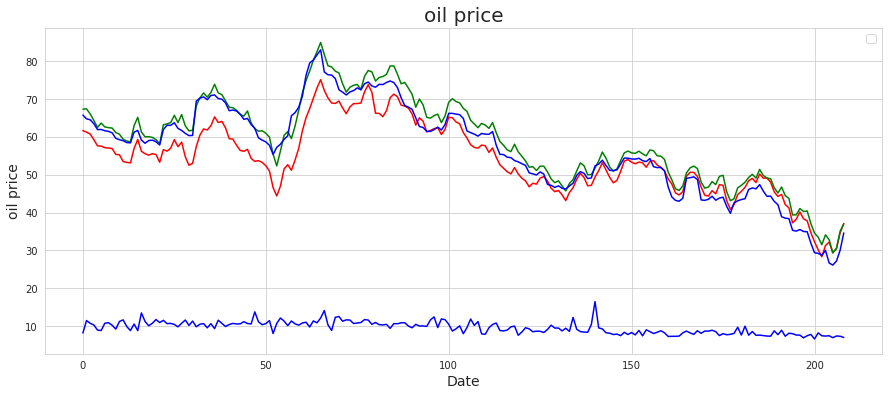

In [58]:
plt.plot(df_m_oil.index, df_m_oil.oil_wti, color='r')
plt.plot(df_m_oil.index, df_m_oil.oil_brent, color='g')
plt.plot(df_m_oil.index, df_m_oil.oil_dubai, color='b')
plt.plot(df_m_oil.index, df_m_oil.price, color='b')

plt.title('oil price', fontsize=20) 
plt.ylabel('oil price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

- 날짜별 유가 종가 그래프와 평균 가격 그래프

## Check

In [59]:
for i in range(1, 53):
  if i not in (list(df_oil_brent[df_oil_brent['year'] == 2019].sort_values(by=['year', 'week'])['week'])):
    print(i)

In [60]:
check_week(df_oil)
check_week(df_oil_dubai)
check_week(df_oil_brent)

missing 0 values
missing 0 values
missing 0 values


세 데이터 모두 결측치가 없음

## Correlation with Price

In [ ]:
# df_list = [df, df_oil, df_oil_dubai, df_oil_brent]

In [68]:
df_m_oil = pd.merge(df,df_oil,on=['year','week'])
df_m_oil.rename(columns = {'oil' : 'oil_wti'}, inplace = True)
df_m_oil = pd.merge(df_m_oil,df_oil_dubai,on=['year','week'])
df_m_oil.rename(columns = {'oil' : 'oil_brent'}, inplace = True)
df_m_oil = pd.merge(df_m_oil,df_oil_brent,on=['year','week'])
df_m_oil.rename(columns = {'oil' : 'oil_dubai'}, inplace = True)

df_m_oil.drop(columns = ['year','week'],inplace=True)

In [69]:
df_oil_corr = df_m_oil.corr()

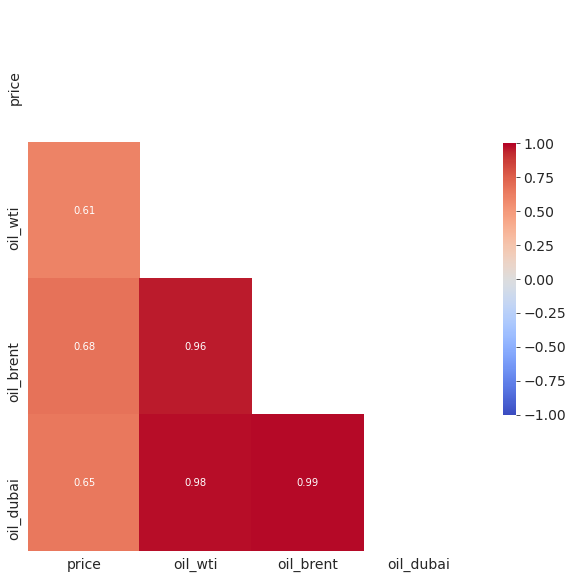

In [70]:
plt.figure(figsize = (10,10))

with plt.style.context({'axes.labelsize':24,
                        'xtick.labelsize':14,
                        'ytick.labelsize':14}):

    mask = np.zeros_like(df_oil_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df_oil_corr, cmap = 'coolwarm', annot = True, mask=mask, cbar_kws={"shrink": .5}, vmin = -1,vmax = 1)

모든 데이터가 결측치는 없지만,  
df_oil 에 해당하는 wti 종가가 가장 예민하게 반응하는 값이므로  
이를 사용하도록 한다

# Korea Weather

## Import Data

In [71]:
df_weather_kr = pd.read_csv(os.path.join(root, 'raw_weather_korea.csv'),
                            encoding='euc-kr',
                            usecols=["일시", "평균 풍속(m/s)", "평균 기온(°C)", "평균 수온(°C)"])

In [72]:
# # plt.fig(figsize = (10,10))

# plt.subplot(311)
# plt.title('평균 풍속(m/s)', fontsize=20) 
# plt.plot(df_weather_kr.index, df_weather_kr['평균 풍속(m/s)'], color='g')

# plt.subplot(312)
# plt.title('평균 기온(°C)', fontsize=20) 
# plt.plot(df_weather_kr.index, df_weather_kr['평균 기온(°C)'], color='b')

# plt.subplot(313)
# plt.title('평균 수온(°C)', fontsize=20) 
# plt.plot(df_weather_kr.index, df_weather_kr['평균 수온(°C)'], color='r')

# plt.tight_layout()
# plt.legend(fontsize=12, loc='best')
# plt.show()

## Preprocess Date

In [73]:
df_weather_kr['date'] = pd.to_datetime(df_weather_kr['일시'].str[:4] + df_weather_kr['일시'].str[5:7] + df_weather_kr['일시'].str[8:])
set_week(df_weather_kr, 'date')

In [74]:
df_weather_kr.describe()

,평균 풍속(m/s),평균 기온(°C),평균 수온(°C),year,week
count,35181.000000,35107.000000,35300.000000,35558.000000,35558.000000
mean,5.732987,14.845689,16.884377,2018.369143,25.531554
std,2.705727,7.573504,5.945493,1.627939,15.146644
min,0.000000,-11.100000,1.100000,2015.000000,1.000000
25%,3.600000,8.800000,13.000000,2017.000000,13.000000
50%,5.400000,15.100000,16.600000,2018.000000,24.000000
75%,7.500000,21.000000,21.400000,2020.000000,39.000000
max,19.600000,34.600000,31.500000,2021.000000,53.000000


## Group
일자 별로 평균 구하기

In [75]:
df_weather_kr['wind_kr'] = df_weather_kr[['year', 'week', '평균 풍속(m/s)']].groupby(['year', 'week']).transform('mean')
df_weather_kr['temperature_kr'] = df_weather_kr[['year', 'week', '평균 기온(°C)']].groupby(['year', 'week']).transform('mean')
df_weather_kr['water_temp_kr'] = df_weather_kr[['year', 'week', '평균 수온(°C)']].groupby(['year', 'week']).transform('mean')

## Drop Column

In [76]:
drop = ['일시', '평균 풍속(m/s)', '평균 기온(°C)', '평균 수온(°C)']

In [77]:
df_weather_kr.drop(columns=drop, inplace=True, axis=1)
df_weather_kr.drop_duplicates(inplace=True)

## Check

In [78]:
check_week(df_weather_kr)

missing 0 values


In [79]:
df_weather_kr.describe()

,year,week,wind_kr,temperature_kr,water_temp_kr
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,2018.267361,25.510417,5.723881,14.920397,16.953522
std,1.612682,15.112121,1.340964,7.177077,5.321755
min,2015.000000,1.000000,2.706723,-0.529915,8.389899
25%,2017.000000,12.750000,4.763866,8.648878,12.088782
50%,2018.000000,24.500000,5.668908,14.792355,16.279115
75%,2020.000000,38.250000,6.656410,21.312062,21.471801
max,2021.000000,53.000000,9.819643,28.610924,28.495798


### Box Plot

Text(0.5, 1.0, 'water temp')

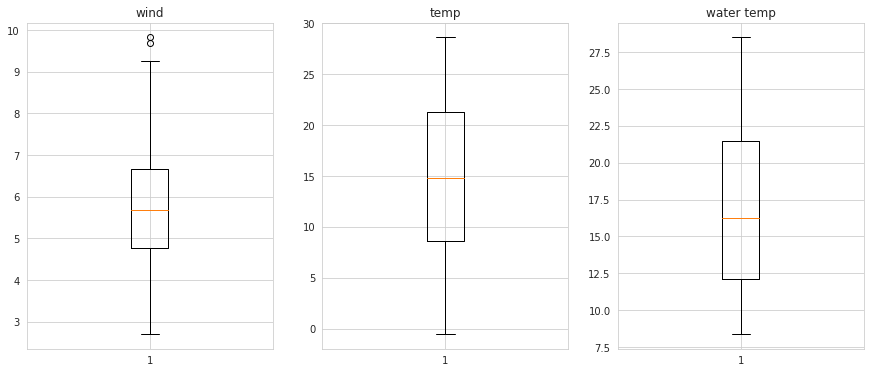

In [80]:
plt.subplot(131)
plt.boxplot(df_weather_kr['wind_kr'])
plt.title('wind')
# plt.ylim(-40,90)

plt.subplot(132)
plt.boxplot(df_weather_kr['temperature_kr'])
plt.title('temp')
# plt.ylim(-40,90)

plt.subplot(133)
plt.boxplot(df_weather_kr['water_temp_kr'])
plt.title('water temp')
# plt.ylim(-40,90)

# plt.show()

이상치가 거의없고 잘 분포되어있다.

## Correlation with Price

In [ ]:
# df_list = [df, df_weather_kr]

In [81]:
df_m_weather_kr = pd.merge(df,df_weather_kr,on=['year','week'])

df_m_weather_kr.drop(columns = ['year','week'],inplace=True)

In [82]:
df_weather_kr_corr = df_m_weather_kr.corr()

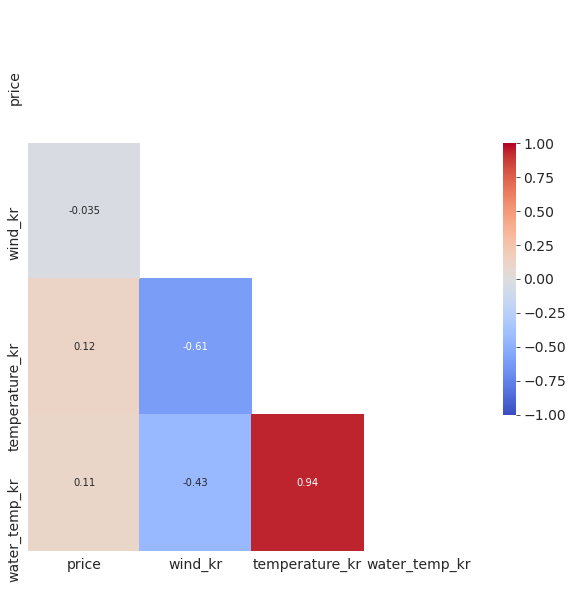

In [83]:
plt.figure(figsize = (10,10))

with plt.style.context({'axes.labelsize':24,
                        'xtick.labelsize':14,
                        'ytick.labelsize':14}):

    mask = np.zeros_like(df_weather_kr_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df_weather_kr_corr, cmap = 'coolwarm', annot = True, mask=mask, cbar_kws={"shrink": .5}, vmin = -1,vmax = 1)

한국의 날씨와 평균단가와의 상관관계는 높지 않다.

# Foreign Weather

## Import Data

In [20]:
df_weather_code = pd.read_csv(os.path.join(root, 'raw_weather_code.csv'), header=0, index_col=0)

In [21]:
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]


## Preprocess
- '지점'에 따른 나라명 컬럼(CTRY_1)과 해안가여부(is_waterfront) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [22]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0]['국가명']


def set_waterfront(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty or data.iloc[0]['해안가여부'] != 1:
        return False
    return True
    

def preprocess_weather(df):
    df = df[(df['강수량'] >= 0) & (df['풍속'] >= 0)] # 이상치/결측치 제거
    set_week(df, '일시')  # 날짜 정보 처리
    
    # 1차 평균
    columns = ['year', 'week', '지점']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')
    
    # 나라명 추가
    df['CTRY_1'] = ""
    for i, row in df.iterrows():
        df.at[i, 'CTRY_1'] = set_country(row)
    
    # 해안가 여부 추가
    df['is_waterfront'] = False
    for i, row in df.iterrows():
        df.at[i, 'is_waterfront'] = set_waterfront(row)
        
#     df = df[df['is_waterfront']]  # 해안가가 아닌 데이터 제외
    
    # 2차 평균
    columns = ['year', 'week', 'CTRY_1']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')

    # 컬럼/행 정리
    df.drop(columns=['지점명', '지점', '강수량', '풍속', '기온', 'is_waterfront'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [23]:
for i in range(len(weather_list)):
    weather_list[i] = preprocess_weather(weather_list[i])

In [24]:
df_weather = pd.concat(weather_list)

## EDA

In [25]:
df_weather

,year,week,rain,wind,temperature,CTRY_1
0,2015,53,3.045833,7.666667,1.728743,노르웨이
1,2016,1,1.507937,5.833333,-6.515079,노르웨이
2,2016,2,0.969388,4.938776,-5.493367,노르웨이
3,2016,3,1.148101,5.265823,-2.363559,노르웨이
4,2016,4,2.282724,6.990033,1.004651,노르웨이
...,...,...,...,...,...,...
159,2021,13,0.290000,5.000000,11.500000,칠레
160,2021,14,0.988889,5.444444,13.744444,칠레
161,2021,17,3.757143,7.828571,11.611429,칠레
162,2021,10,1.545455,6.909091,11.400000,칠레


## Check

In [26]:
df_weather.describe()

,year,week,rain,wind,temperature
count,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000
mean,2018.232877,25.856462,5.981158,3.642640,14.906772
std,1.607481,15.124088,32.371218,3.200572,10.536941
min,2015.000000,1.000000,0.000000,0.000000,-21.600000
25%,2017.000000,13.000000,1.489908,1.869608,8.266627
50%,2018.000000,25.000000,2.750000,2.452555,15.382857
75%,2020.000000,39.000000,6.504304,5.111601,25.430698
max,2021.000000,53.000000,915.000000,60.000000,30.100000


In [27]:
for country in df_weather['CTRY_1'].unique():
    if country == "":
        continue
    print()
    print(country, "총", len(df_weather[df_weather['CTRY_1'] == country]), "개")
    check_week(df_weather[df_weather['CTRY_1'] == country])


노르웨이 총 236 개
missing 0 values

태국 총 297 개
(2016, 11)
missing 1 values

베트남 총 298 개
(2016, 6)
missing 1 values

중국 총 299 개
missing 0 values

페루 총 7 개
(2015, 53)(2016, 1)(2016, 2)(2016, 3)(2016, 4)(2016, 5)(2016, 6)(2016, 7)(2016, 8)(2016, 9)(2016, 10)(2016, 11)(2016, 12)(2016, 13)(2016, 14)(2016, 15)(2016, 16)(2016, 17)(2016, 18)(2016, 19)(2016, 20)(2016, 21)(2016, 22)(2016, 23)(2016, 24)(2016, 25)(2016, 26)(2016, 27)(2016, 28)(2016, 29)(2016, 30)(2016, 31)(2016, 32)(2016, 33)(2016, 34)(2016, 35)(2016, 36)(2016, 37)(2016, 38)(2016, 39)(2016, 40)(2016, 41)(2016, 42)(2016, 43)(2016, 44)(2016, 45)(2016, 46)(2016, 47)(2016, 48)(2016, 49)(2016, 51)(2016, 52)(2017, 1)(2017, 2)(2017, 3)(2017, 4)(2017, 5)(2017, 6)(2017, 7)(2017, 8)(2017, 9)(2017, 10)(2017, 12)(2017, 13)(2017, 14)(2017, 15)(2017, 16)(2017, 17)(2017, 18)(2017, 19)(2017, 20)(2017, 21)(2017, 22)(2017, 23)(2017, 24)(2017, 25)(2017, 26)(2017, 27)(2017, 28)(2017, 29)(2017, 30)(2017, 31)(2017, 32)(2017, 33)(2017, 34)(2017, 35)(2017, 3

## Filling Missing Values

- 노르웨이, 중국은 결측치 없음
- 태국, 베트남, 칠레는 결측치 1개
> 전/차주 데이터 평균으로 채워넣기
- 페루는 결측치 299개
> 사용 불가로 판단

In [28]:
def get_avg(year, week, country, value):
  return (df_weather[(df_weather['year'] == year) & (df_weather['week'] == week + 1) & (df_weather['CTRY_1'] == country)].iloc[0][value] 
          + df_weather[(df_weather['year'] == year) & (df_weather['week'] == week - 1) & (df_weather['CTRY_1'] == country)].iloc[0][value]) / 2

In [29]:
df_weather = df_weather.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(2016, 11, '태국', 'rain'),
                                'wind': get_avg(2016, 11, '태국', 'wind'),
                                'temperature': get_avg(2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather = df_weather.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(2016, 6, '베트남', 'rain'),
                                'wind': get_avg(2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(2016, 6, '베트남', 'temperature')},
                               ignore_index=True)
df_weather = df_weather.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(2016, 5, '칠레', 'rain'),
                                'wind': get_avg(2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather[df_weather['CTRY_1'] == country]), "개")
    check_week(df_weather[df_weather['CTRY_1'] == country])


태국 총 298 개
missing 0 values

베트남 총 299 개
missing 0 values

칠레 총 298 개
missing 0 values


## Correlation with Price

In [110]:
# df_m_weather = pd.merge(df,df_weather,on=['year','week'])

In [111]:
# country_list = ['중국','베트남','태국','노르웨이','칠레']

# for name in country_list:
#     df_m_weather[name] = 0
#     df_m_weather.loc[df_m_weather['CTRY_1'].str.contains(name, regex=False), name] = 1       

In [112]:
# df_m_weather.rename(columns = {'중국':'china','베트남':'vietnam','태국':'thai','노르웨이':'norway','칠레':'chile'},inplace = True)

In [113]:
# df_weather_corr = df_m_weather.corr()

In [116]:
# plt.figure(figsize = (10,10))

# with plt.style.context({'axes.labelsize':24,
#                         'xtick.labelsize':14,
#                         'ytick.labelsize':14}):

#     mask = np.zeros_like(df_weather_corr, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True
#     sns.heatmap(df_weather_corr, cmap = 'coolwarm', annot = True, mask=mask, cbar_kws={"shrink": .5}, vmin = -1,vmax = 1)

In [121]:
df_1 = df_weather[df_weather['CTRY_1'] == '노르웨이'].copy()
df_1.rename(columns = {'rain' :'nor_rain', 'wind' : 'nor_wind', 'temperature' : 'nor_temp'}, inplace = True)
df_1.drop('CTRY_1',axis=1, inplace = True)

df_2 = df_weather[df_weather['CTRY_1'] == '태국'].copy()
df_2.rename(columns = {'rain' :'tai_rain', 'wind' : 'tai_wind', 'temperature' : 'tai_temp'}, inplace = True)
df_2.drop('CTRY_1',axis=1, inplace = True)

df_3 = df_weather[df_weather['CTRY_1'] == '베트남'].copy()
df_3.rename(columns = {'rain' :'vie_rain', 'wind' : 'vie_wind', 'temperature' : 'vie_temp'}, inplace = True)
df_3.drop('CTRY_1',axis=1, inplace = True)

df_4 = df_weather[df_weather['CTRY_1'] == '중국'].copy()
df_4.rename(columns = {'rain' :'chn_rain', 'wind' : 'chn_wind', 'temperature' : 'chn_temp'}, inplace = True)
df_4.drop('CTRY_1',axis=1, inplace = True)

df_5 = df_weather[df_weather['CTRY_1'] == '칠레'].copy()
df_5.rename(columns = {'rain' :'chl_rain', 'wind' : 'chl_wind', 'temperature' : 'chl_temp'}, inplace = True)
df_5.drop('CTRY_1',axis=1, inplace = True)

In [122]:
df_list = [df,df_1,df_2,df_3,df_4,df_5]

df_m_weather = reduce(lambda left, right: pd.merge(left, right, on=['year','week']), df_list)

In [123]:
df_m_weather.drop(columns = ['year','week'],inplace=True)

In [124]:
df_weather_corr = df_m_weather.corr()

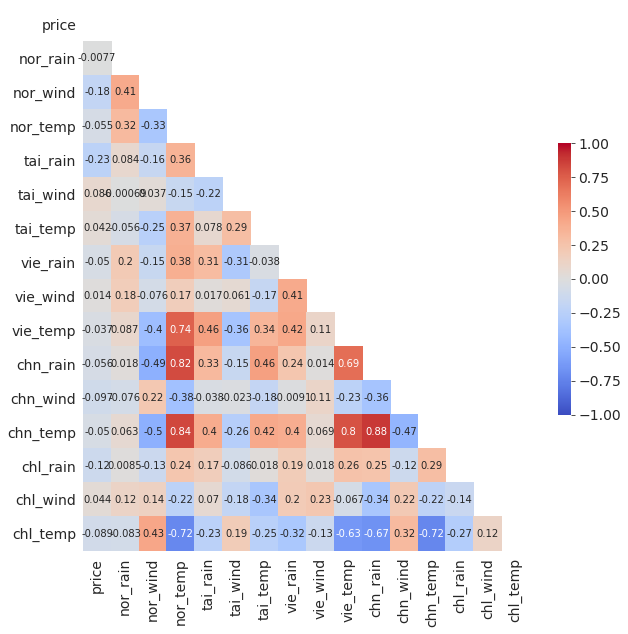

In [126]:
plt.figure(figsize = (10,10))

with plt.style.context({'axes.labelsize':24,
                        'xtick.labelsize':14,
                        'ytick.labelsize':14}):

    mask = np.zeros_like(df_weather_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df_weather_corr, cmap = 'coolwarm', annot = True, mask=mask, cbar_kws={"shrink": .5}, vmin = -1,vmax = 1)

- 전체 평균가격과 비교했을 때, 상관관계가 없어보인다.

## Correlation with Each Price

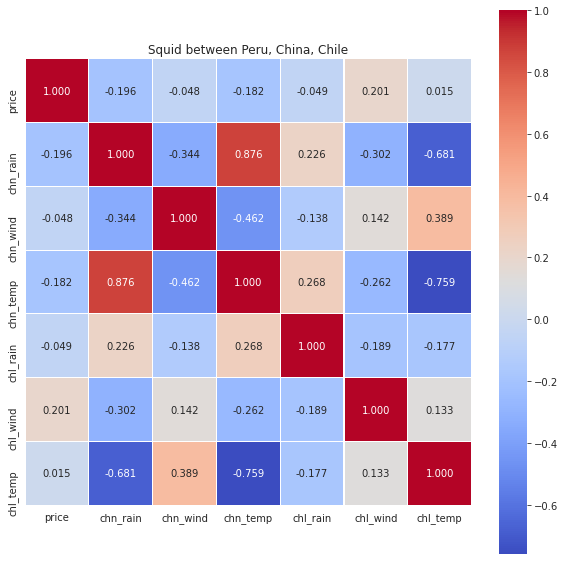

In [44]:
df_list = [squid_price,df_4,df_5]

df_m_weather = reduce(lambda left, right: pd.merge(left, right, on=['year','week']), df_list)
df_m_weather.drop(columns = ['year','week'],inplace=True)

corr = df_m_weather.corr() 

plt.figure(figsize= (10,10))
plt.title('Squid between Peru, China, Chile')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

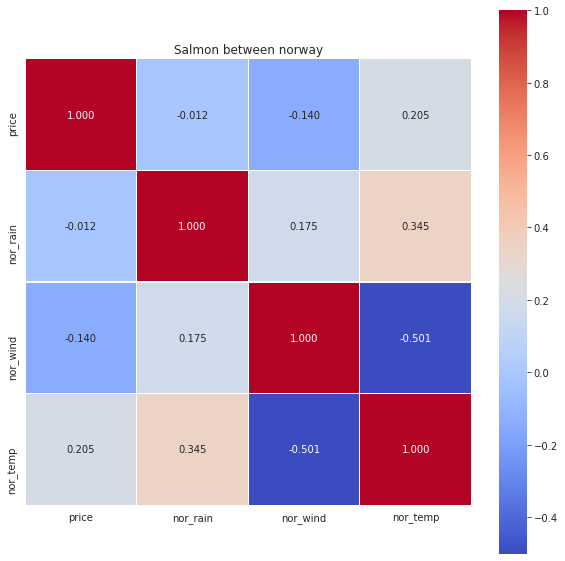

In [45]:
df_list = [salmon_price,df_1]

df_m_weather = reduce(lambda left, right: pd.merge(left, right, on=['year','week']), df_list)
df_m_weather.drop(columns = ['year','week'],inplace=True)

corr = df_m_weather.corr() 

plt.figure(figsize= (10,10))
plt.title('Salmon between norway')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

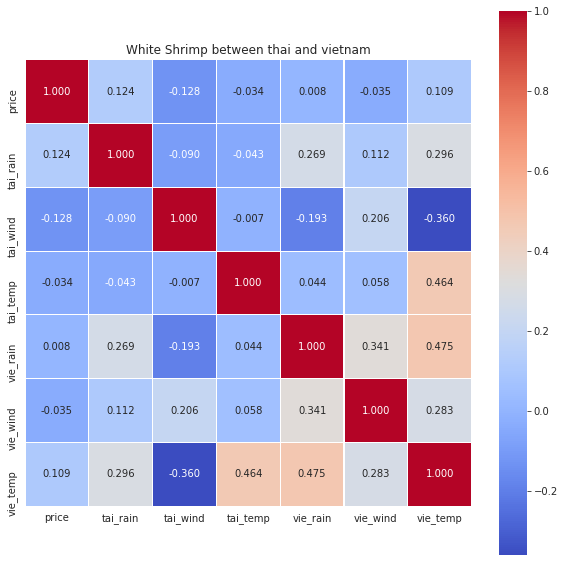

In [46]:
df_list = [wshrimp_price,df_2,df_3]

df_m_weather = reduce(lambda left, right: pd.merge(left, right, on=['year','week']), df_list)
df_m_weather.drop(columns = ['year','week'],inplace=True)

corr = df_m_weather.corr() 

plt.figure(figsize= (10,10))
plt.title('White Shrimp between thai and vietnam')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

# CPI

## Import Data

In [84]:
df_cpi_total = pd.read_csv(os.path.join(root, 'raw_cpi_total.csv'), encoding='cp949')  # 총 소비자물가지수
df_cpi_fish =  pd.read_csv(os.path.join(root, 'raw_cpi_fish.csv'), encoding='cp949')  # 수산물 소비자물가지수

## Drop Columns/Rows

In [85]:
df_cpi_total = df_cpi_total[df_cpi_total['지출목적별'] == "0 총지수"].drop(columns=['시도별', '지출목적별'], axis=1)
df_cpi_fish = df_cpi_fish[df_cpi_fish['지출목적별'] == "어류 및 수산"].drop(columns=['Unnamed: 0', '지출목적별'], axis=1)

## Pivoting

In [86]:
df_cpi_total = df_cpi_total.transpose().reset_index()
df_cpi_fish = df_cpi_fish.transpose().reset_index()

## Rename

In [87]:
df_cpi_total.rename(columns={0: 'cpi_total'}, inplace=True)
df_cpi_fish.rename(columns={0: 'cpi_fish'}, inplace=True)
print(df_cpi_total.columns, df_cpi_fish.columns)

Index(['index', 'cpi_total'], dtype='object') Index(['index', 'cpi_fish'], dtype='object')


## Preprocess Date

In [88]:
df_cpi_total['year'] = df_cpi_total['index'].str[:4].astype('int')
df_cpi_total['month'] = df_cpi_total['index'].str[6:8].astype('int')
df_cpi_fish['year'] = df_cpi_fish['index'].str[:4].astype('int')
df_cpi_fish['month'] = df_cpi_fish['index'].str[6:8].astype('int')

In [89]:
df_cpi_total.drop(columns=['index'], inplace=True)
df_cpi_fish.drop(columns=['index'], inplace=True)

In [90]:
# Merge df
df_cpi = pd.merge(left=df_cpi_total, right=df_cpi_fish, how='outer', on=['year', 'month'])

In [91]:
# create days by duplicating data
new_df = pd.DataFrame(columns=list(df_cpi.columns) + ['day'])
for i, row in df_cpi.iterrows():
  data = df_cpi.iloc[i]
  year, month, cpi_total, cpi_fish = data['year'].astype('int'), data['month'].astype('int'), data['cpi_total'], data['cpi_fish']
  for day in range(1, monthrange(year, month)[1]+1):
    new_df = new_df.append({'year': str(year),
                            'month': str(month),
                            'day': str(day),
                            'cpi_total': cpi_total,
                            'cpi_fish': cpi_fish},
                           ignore_index=True)
df_cpi = new_df

In [92]:
df_cpi['date'] = df_cpi['year'] + " " + df_cpi['month'] + " " + df_cpi['day']

In [93]:
set_week(df_cpi, 'date')

## 정리
- drop unused columns
- drop duplicates

In [94]:
df_cpi.drop(columns=['month', 'day'], inplace=True)
df_cpi.drop_duplicates(inplace=True)

## Check

In [95]:
check_week(df_cpi)

missing 0 values


In [96]:
df_cpi.describe()

,cpi_total,year,cpi_fish,week
count,348.000000,353.000000,353.000000,353.000000
mean,103.977759,2018.254958,112.068300,26.067989
std,1.901079,1.659215,6.449167,15.191427
min,100.220000,2015.000000,100.760000,1.000000
25%,102.720000,2017.000000,107.370000,13.000000
50%,104.350000,2018.000000,111.960000,26.000000
75%,105.460000,2020.000000,118.440000,39.000000
max,107.460000,2021.000000,122.010000,53.000000


In [97]:
df_cpi.sample(5)

,cpi_total,year,cpi_fish,week
943,103.93,2018,112.65,26
412,102.64,2017,107.37,3
1973,107.39,2021,121.79,17
286,101.46,2016,102.01,37
974,104.85,2018,111.37,31


## Correlation with Price

In [99]:
df_m_cpi = pd.merge(df,df_cpi,on=['year','week'])
df_m_cpi.drop(columns = ['year','week'],inplace=True)

In [100]:
df_cpi_corr = df_m_cpi.corr()

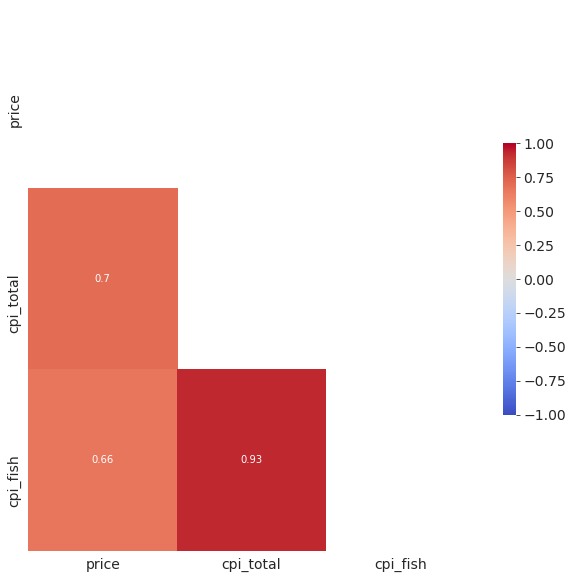

In [101]:
plt.figure(figsize = (10,10))

with plt.style.context({'axes.labelsize':24,
                        'xtick.labelsize':14,
                        'ytick.labelsize':14}):

    mask = np.zeros_like(df_cpi_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df_cpi_corr, cmap = 'coolwarm', annot = True, mask=mask, cbar_kws={"shrink": .5}, vmin = -1,vmax = 1)

- CPI와 price의 상관관계가 높게 측정된다.

# Exchange

### exchange_money setting

In [ ]:
# def exchange_money(nation = None, df = df, name=None):
#   nation['날짜'] = nation['날짜'].str.replace('년 ','-')
#   nation['날짜'] = nation['날짜'].str.replace('월 ','-')
#   nation['날짜'] = nation['날짜'].str.replace('일','')

#   nation['날짜'] = nation['날짜'].astype('datetime64')

#   nation = nation.query('날짜.dt.dayofweek == 0')
#   nation = nation[nation['날짜']<='2019-12-30']
#   nation = nation[['날짜','종가']]

#   nation = nation.sort_index(ascending=True)
#   is_nan = nation.isna().sum()

#   if len(nation['날짜'].unique()) != len(df['기준일'].unique()):
#     diff = len(df.query('기준일.dt.dayofweek == 0')['기준일'].unique()) - len(nation['날짜'].unique())
#     print('{}은 {}개의 결측치 존재'.format(name, diff))

#   return nation

## Import Data

In [ ]:
vietnam = pd.read_csv(os.path.join(root, 'raw_exchange_vietnam.csv'),usecols=['날짜','종가']) 
thai = pd.read_csv(os.path.join(root, 'raw_exchange_thai.csv'),usecols=['날짜','종가']) 
peru = pd.read_csv(os.path.join(root, 'raw_exchange_peru.csv'),usecols=['날짜','종가']) 
norway = pd.read_csv(os.path.join(root, 'raw_exchange_norway.csv'),usecols=['날짜','종가'])
china = pd.read_csv(os.path.join(root, 'raw_exchange_china.csv'),usecols=['날짜','종가'])
chile = pd.read_csv(os.path.join(root, 'raw_exchange_chile.csv'),usecols=['날짜','종가']) 

## Preprocessing

주요 국가의 환율 데이터의 날짜 데이터를 주차 데이터로 만들어 빠진 주가 없는지 확인

In [ ]:
def set_date(df,date):
    df[date] = pd.to_datetime(df[date].str[:4] + df[date].str[5:7] + df[date].str[8:])
    set_week(df, date)

- 베트남 환율(2015~2019년 베트남 환율)

In [ ]:
set_date(vietnam,'날짜')

df_test = pd.DataFrame([])
df_test[['year','week']]=vietnam[['year','week']]
df_test['종가']=vietnam.groupby(['year','week'])['종가'].transform('mean')
df_test.drop_duplicates(['year','week'],inplace=True)
vietnam = df_test
vietnam

,year,week,종가
0,2021,26,0.000043
1,2021,25,0.000043
6,2021,24,0.000044
11,2021,23,0.000044
16,2021,22,0.000043
...,...,...,...
1399,2016,4,0.000045
1404,2016,3,0.000045
1409,2016,2,0.000045
1414,2016,1,0.000044


- 태국( 2015~2019년 태국 환율 )

In [ ]:
set_date(thai,'날짜')
thai

,종가,year,week
0,0.0277,2015,53
1,0.0277,2016,1
2,0.0276,2016,2
3,0.0275,2016,3
4,0.0278,2016,4
...,...,...,...
283,0.0320,2021,22
284,0.0321,2021,23
285,0.0321,2021,24
286,0.0316,2021,25


- 페루 환율(2015~2019년 페루 환율)

In [ ]:
set_date(peru,'날짜')
peru

,종가,year,week
0,0.2943,2015,53
1,0.2930,2016,1
2,0.2916,2016,2
3,0.2913,2016,3
4,0.2887,2016,4
...,...,...,...
283,0.2603,2021,22
284,0.2539,2021,23
285,0.2564,2021,24
286,0.2528,2021,25


- 노르웨이 환율(2015 ~ 2019년 노르웨이 환율)

In [ ]:
set_date(norway,'날짜')
norway

,종가,year,week
0,0.1149,2015,53
1,0.1126,2016,1
2,0.1119,2016,2
3,0.1124,2016,3
4,0.1142,2016,4
...,...,...,...
283,0.1201,2021,22
284,0.1210,2021,23
285,0.1203,2021,24
286,0.1166,2021,25


- 중국 환율(2015~2019년 중국 환율)

In [ ]:
set_date(china,'날짜')
china

,종가,year,week
0,0.1541,2015,53
1,0.1530,2016,1
2,0.1522,2016,2
3,0.1520,2016,3
4,0.1520,2016,4
...,...,...,...
283,0.1570,2021,22
284,0.1563,2021,23
285,0.1563,2021,24
286,0.1546,2021,25


- 2015~2019년 칠레 환율

In [ ]:
set_date(chile,'날짜')
chile

,종가,year,week
0,0.001400,2015,53
1,0.001400,2016,1
2,0.001400,2016,2
3,0.001400,2016,3
4,0.001400,2016,4
...,...,...,...
283,0.001382,2021,22
284,0.001395,2021,23
285,0.001389,2021,24
286,0.001337,2021,25


## Check

In [ ]:
check_week(vietnam)

missing 0 values


In [ ]:
check_week(thai)

missing 0 values


In [ ]:
check_week(peru)

missing 0 values


In [ ]:
check_week(norway)

missing 0 values


In [ ]:
check_week(china)

missing 0 values


In [ ]:
check_week(chile)

missing 0 values


## Correlation

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


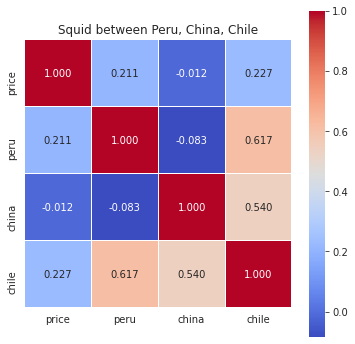

In [ ]:
corr = pd.DataFrame({'price':squid_price['price'],
                    'peru':peru['종가'],
                    'china':china['종가'],
                    'chile':chile['종가']}).corr() 

plt.figure(figsize= (6, 6))
plt.title('Squid between Peru, China, Chile')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

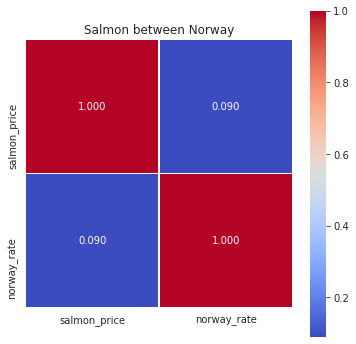

In [ ]:
corr = pd.DataFrame({'salmon_price':salmon_price['price'],
                    'norway_rate':norway['종가']}).corr()


plt.figure(figsize= (6, 6))
plt.title('Salmon between Norway')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', 
            annot=True, linewidths = 0.1, linecolor='white', square = True)

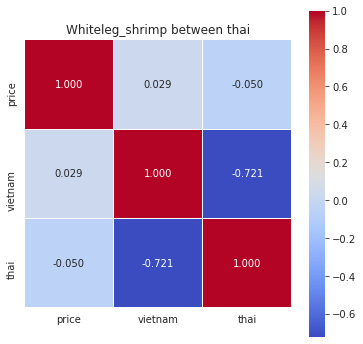

In [ ]:
corr = pd.DataFrame({'price':wshrimp_price['price'],
                    'vietnam' : vietnam['종가'],     
                    'thai':thai['종가']
             }).corr()

plt.figure(figsize= (6, 6))
plt.title('Whiteleg_shrimp between thai and vietnam')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

칠레와 페루는 주요 품목인 오징어에 대하여 상관관계가 어느정도 있다고 나옴
나머지는 각국의 환율과 각국에 대한 품목의 상관관계에서 큰 상관이 없다고 나옴


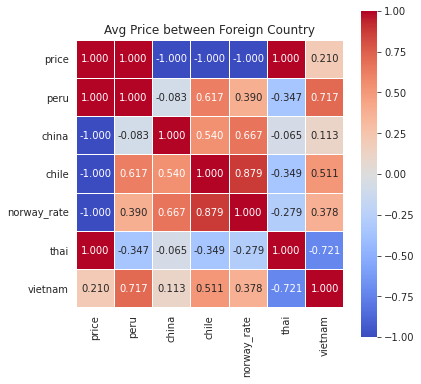

In [ ]:
corr = pd.DataFrame({'price':df['price'],
            'peru':peru['종가'],
            'china':china['종가'],
            'chile':chile['종가'],
            'norway_rate':norway['종가'],
            'thai':thai['종가'],
            'vietnam' : vietnam['종가']}
             ).corr() 

plt.figure(figsize= (6, 6))
plt.title('Avg Price between Foreign Country')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

전체 평균가격과 주요국 환율과의 관계